# Import library 

In [1]:
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# GET DATA

In [60]:
%cd /content

/content


In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!wget http://images.cocodataset.org/zips/train2017.zip  

--2023-01-02 05:51:53--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.21.141, 52.217.69.28, 52.217.76.156, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.21.141|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  30.8MB/s    in 35s     

2023-01-02 05:52:28 (22.0 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2023-01-02 05:52:29--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.236.1, 52.216.169.219, 54.231.131.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.236.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%

In [ ]:
!unzip train2017.zip
!rm -rf train2017.zip
!unzip val2017.zip
!rm -rf val2017.zip
!unzip annotations_trainval2017.zip
!rm -rf annotations_trainval2017.zip


In [ ]:
!python train.py --dataset coco --coco_path /content/coco2017 --depth 50 --epochs 2

CUDA available: True
loading annotations into memory...
Traceback (most recent call last):
  File "train.py", line 180, in <module>
    main()
  File "train.py", line 43, in main
    dataset_train = CocoDataset(parser.coco_path, set_name='train2017',
  File "/content/drive/MyDrive/Retinanet/pytorch-retinanet/retinanet/dataloader.py", line 37, in __init__
    self.coco      = COCO(os.path.join(self.root_dir, 'annotations', 'instances_' + self.set_name + '.json'))
  File "/usr/local/lib/python3.8/dist-packages/pycocotools/coco.py", line 81, in __init__
    with open(annotation_file, 'r') as f:
FileNotFoundError: [Errno 2] No such file or directory: '/content/coco2017/annotations/instances_train2017.json'
^C


# Testing processing

In [ ]:
%cd /content/drive/MyDrive/Retinanet/pytorch-retinanet

/content/drive/MyDrive/Retinanet/pytorch-retinanet


In [ ]:
!python coco_validation.py --coco_path /content/drive/MyDrive/Retinanet/coco2017 --model_path /content/drive/MyDrive/Retinanet/coco_resnet_50_map_0_335_state_dict.pt

# Inference Mode 

In [4]:
import torch
from retinanet import model

retinanet = model.resnet50(num_classes=80,)
retinanet.load_state_dict(torch.load('/content/drive/MyDrive/Retinanet/coco_resnet_50_map_0_335_state_dict.pt'))

<All keys matched successfully>

**UPLOAD ẢNH**

In [5]:
from google.colab import files
uploaded = files.upload()
j = list((uploaded.keys()))[0]


Saving 1.png to 1.png


In [6]:
%matplotlib inline

img_path = '/content/drive/MyDrive/Retinanet/pytorch-retinanet/'+str(j)

In [57]:
from __future__ import print_function
from PIL import Image
import matplotlib.pyplot  as plt

import torch
import numpy as np
import time
import os
import cv2

COLORS = np.random.uniform(0, 255, size=(81, 3))
# Draws caption
def draw_caption(image, box, caption,idx):
    b = np.array(box).astype(int)
    color = COLORS[idx]
    cv2.putText(image, caption, (int(box[0]), int(box[1]+10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                lineType=cv2.LINE_AA)

def predict(img_path,retinanet):
    labels = {0: 'person',1: 'bicycle',2: 'car',3: 'motorcycle',4: 'airplane',5: 'bus',6: 'train',7: 'truck',8: 'boat',9: 'traffic light',10: 'fire hydrant',11: 'stop sign',12: 'parking meter',13: 'bench',14: 'bird',15: 'cat',16: 'dog',17: 'horse',18: 'sheep',19: 'cow',20: 'elephant',21: 'bear',22: 'zebra',23: 'giraffe',24: 'backpack',25: 'umbrella',26: 'handbag',27: 'tie',28: 'suitcase',29: 'frisbee',30: 'skis',31: 'snowboard',32: 'sports ball',33: 'kite',34: 'baseball bat',35: 'baseball glove',36: 'skateboard',37: 'surfboard',38: 'tennis racket',39: 'bottle',40: 'wine glass',41: 'cup',42: 'fork',43: 'knife',44: 'spoon',45: 'bowl',46: 'banana',47: 'apple',48: 'sandwich',49: 'orange',50: 'broccoli',51: 'carrot',52: 'hot dog',53: 'pizza',54: 'donut',55: 'cake',56: 'chair',57: 'couch',58: 'potted plant',59: 'bed',60: 'dining table',61: 'toilet',62: 'tv',63: 'laptop',64: 'mouse',65: 'remote',66: 'keyboard',67: 'cell phone',68: 'microwave',69: 'oven',70: 'toaster',71: 'sink',72: 'refrigerator',73: 'book',74: 'clock',75: 'vase',76: 'scissors', 77: 'teddy bear',78: 'hair drier',79: 'toothbrush'}
    image =  cv2.imread(img_path)

    if torch.cuda.is_available():
        retinanet = retinanet.cuda()

    retinanet.eval()
    image_orig = image.copy()

    rows, cols, cns = image.shape

    smallest_side = min(rows, cols)

    # rescale the image so the smallest side is min_side
    min_side = 608
    max_side = 1024
    scale = min_side / smallest_side

    # check if the largest side is now greater than max_side, which can happen
    # when images have a large aspect ratio
    largest_side = max(rows, cols)

    if largest_side * scale > max_side:
        scale = max_side / largest_side

    # resize the image with the computed scale
    image = cv2.resize(image, (int(round(cols * scale)), int(round((rows * scale)))))
    rows, cols, cns = image.shape

    pad_w = 32 - rows % 32
    pad_h = 32 - cols % 32

    new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
    new_image[:rows, :cols, :] = image.astype(np.float32)
    image = new_image.astype(np.float32)
    image /= 255
    image -= [0.485, 0.456, 0.406]
    image /= [0.229, 0.224, 0.225]
    image = np.expand_dims(image, 0)
    image = np.transpose(image, (0, 3, 1, 2))

    with torch.no_grad():

        image = torch.from_numpy(image)
        if torch.cuda.is_available():
            image = image.cuda()

        st = time.time()
        scores, classification, transformed_anchors = retinanet(image.cuda().float())
        print('Elapsed time: {}'.format(time.time() - st))
        idxs = np.where(scores.cpu() > 0.5)

        for j in range(idxs[0].shape[0]):
            bbox = transformed_anchors[idxs[0][j], :]

            x1 = int(bbox[0] / scale)
            y1 = int(bbox[1] / scale)
            x2 = int(bbox[2] / scale)
            y2 = int(bbox[3] / scale)
            label_name = labels[int(classification[idxs[0][j]])]
            score = scores[j]
            caption = (label_name)
            draw_caption(image_orig, (x1, y1, x2, y2), caption,int(classification[idxs[0][j]]))
            cv2.rectangle(image_orig, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)

    plt.imshow(image_orig)


Elapsed time: 0.17045807838439941


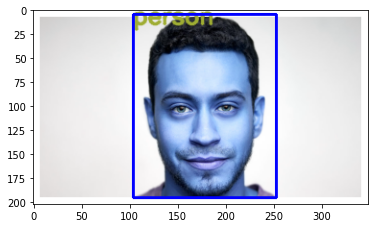

In [56]:
predict(img_path,retinanet)

# Some reference 
https://github.com/yhenon/pytorch-retinanet